## Apply NN to recover the theory of diffraction

- Dongming Jin


My idea is that morden science is closely related to technical innovation. But back in the 80s and 90s, mechanical engineering and manufactory is still in the infancy, as well as data sampling and analytic methods. Even though the foundation of morden science is considered solid and proven, there is still chance that the perspective we have is not the only solution. Just like Newtonian gravity theory is an approximation of general relativity. 

To explore and test it out, I first decide to do a simulation based on established theory to get example data. Diffraction is one of the most classic phenomenon that is well explained but also is explosured to the dawn of Quantum mechanics. To make it more realistic, I add white noise as systemactical error due to measurement and try to use ML, (a straightforward neural network in this case) to reveal the nature of the problem. But due to the high percision it required to realize the numerical experiment, I run into some data format issue that couldn't be solved in short timeframe. 

So I decide to use gaussian process regression with the morden statistical method, Bayesian inference to catch the hidden nature from a small uniform random sampling data set. I put flat prior to avoid any prejustical knowledge about model and GP returned a reasonable good result, without excluding the possibility of alternative diffraction theory. See Cell 43 and Cell 45. The red dots are sampled based on theory, black dots with flat error bar are the data used to explore the model space. The _color density_ indicates the probability and Cell 26 shows the fructuation from measurement. 

My next step is to establish a mechanical system based on raspberrypi and step motor to stimulate in real case. Use the data measured in a large scale to revisit my temperate conclusion. 


### REF
* [paper about Optics simulations with python](https://www.osapublishing.org/DirectPDFAccess/47E6CA42-FADB-6891-CA9B67A17E5174B4_354793/ETOP-2015-DTE14.pdf?da=1&id=354793&uri=ETOP-2015-DTE14&seq=0&mobile=no)

* [github for python code](https://github.com/kalekundert/DoubleSlit)

* [wiki about diffraction](https://en.wikipedia.org/wiki/Diffraction)

In [1]:
%pylab inline
from decimal import Decimal
import math

Populating the interactive namespace from numpy and matplotlib


### 1-D diffraction

$\frac{I(x)}{I(0)}= \left[ \frac{\sin(\frac{\pi b}{\lambda}\frac{x}{D}) }{(\frac{\pi b}{\lambda} \frac{x}{D} )} \right]^2$

* $b$: slit width
* $\lambda$: wavelength
* $D$: distance to screen

In [2]:
d_b = Decimal(1.E-6)  # 1 micron
d_lambda = Decimal(float(600)*1.E-9)  # 600 nm
d_D = Decimal(float(100)*1.E-2)  # 1 m

In [3]:
measurement = 99
omega = pi/3.  # solid angel by half
d_x = np.array([Decimal(i) * Decimal(math.tan(omega)) + Decimal(np.random.normal(scale=0.01))
              for i in linspace(-1, 1, measurement*2)])
# x = np.array([Decimal(np.random.uniform(-1, 1)) * Decimal(math.tan(omega)) 
#              for i in range(measurement*2)])

In [4]:
def Fraunhofe(x, params):
    b, lamda, D = params
    if size(x) == 1:
        return (Decimal(math.sin(Decimal(pi)*b/lamda*x/D))/(Decimal(pi)*b/lamda*x/D))**2
    return np.array([(Decimal(math.sin(Decimal(pi)*b/lamda*i/D))/(Decimal(pi)*b/lamda*i/D))**Decimal(2) +
                     Decimal(np.random.normal(scale=0.01))
                     for i in x])

In [5]:
d_I = Fraunhofe(d_x, [d_b, d_lambda, d_D])

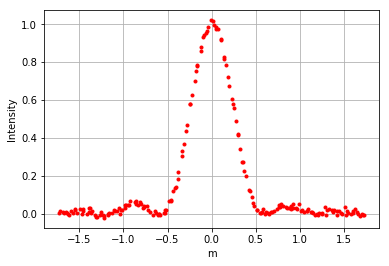

In [6]:
fig = figure()
ax1=fig.add_subplot(1,1,1)
ax1.plot(d_x, d_I,'r.')
ax1.set_xlabel('m')
ax1.set_ylabel('Intensity')
ax1.grid(True)

In [7]:
assert size(d_I) == measurement*2

In [8]:
import tensorflow as tf

In [57]:
dm_input = measurement * 2 + 3
dm_output = measurement * 2

x = tf.placeholder(tf.float32, [None, dm_input])
W = tf.Variable(tf.zeros([dm_input, dm_output]))
b = tf.Variable(tf.zeros([dm_output]))

In [10]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

In [11]:
y_ = tf.placeholder(tf.float32, [None, dm_output])

In [12]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

In [13]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [14]:
sess = tf.InteractiveSession()

In [15]:
tf.global_variables_initializer().run()

In [16]:
for _ in range(1000):
    d_x = np.array([Decimal(np.random.uniform(-1, 1)) * Decimal(math.tan(omega)) 
                         for i in range(measurement*2)])
    d_b = Decimal(1.E-6 * np.random.uniform(1,10))  # 1 micron
    d_lambda = Decimal(float(600) * np.random.uniform(1,10) * 1.E-9)  # 600 nm
    d_D = Decimal(float(100) * np.random.uniform(1,10) * 1.E-2)  # 1 m

    batch_xs = np.append(d_x,[d_b, d_lambda, d_D]).reshape(-1, dm_input)
    batch_ys = Fraunhofe(d_x, [d_b, d_lambda, d_D]).reshape(-1, dm_output)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [17]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [64]:
d_x = np.array([Decimal(np.random.uniform(-1, 1)) * Decimal(math.tan(omega)) 
                     for i in range(measurement*2)])
d_b = Decimal(1.E-6 * np.random.uniform(1,10))  # 1 micron
d_lambda = Decimal(float(600) * np.random.uniform(1,10) * 1.E-9)  # 600 nm
d_D = Decimal(float(100) * np.random.uniform(1,10) * 1.E-2)  # 1 m

batch_xs = np.append(d_x,[d_b, d_lambda, d_D]).reshape(-1, dm_input)

In [65]:
x.shape

TensorShape([Dimension(None), Dimension(201)])

In [66]:
batch_xs.shape

(1, 201)

In [67]:
predictions = sess.run(accuracy, feed_dict={x: batch_xs})

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [?,198]
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[?,198], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder_1', defined at:
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-0efc4b727a1c>", line 1, in <module>
    y_ = tf.placeholder(tf.float32, [None, dm_output])
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1548, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2094, in _placeholder
    name=name)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [?,198]
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[?,198], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [22]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from numpy.random import multivariate_normal
from numpy.linalg import inv
from numpy.linalg import slogdet
from scipy.optimize import fmin

In [23]:
def SEKernel(par, x1, x2):
    A, Gamma = par
    D2 = cdist(x1.reshape(len(x1),1), x2.reshape(len(x2),1), 
               metric = 'sqeuclidean')
    return A * np.exp(-Gamma*D2)

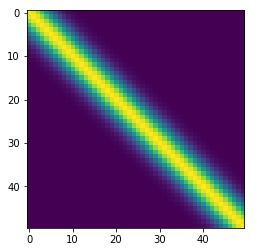

In [24]:
x = np.linspace(-5,5,50)
K = SEKernel([1.0,1.0],x,x)

plt.imshow(K,interpolation='none');

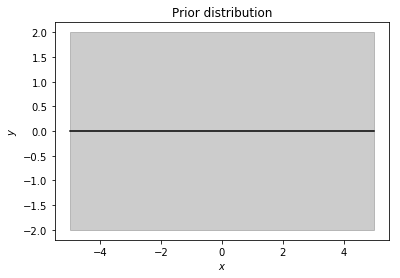

In [25]:
m = np.zeros(len(x))
sig = np.sqrt(np.diag(K))
plt.plot(x,m,'k-')
plt.fill_between(x,m+2*sig,m-2*sig,color='k',alpha=0.2)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Prior distribution');

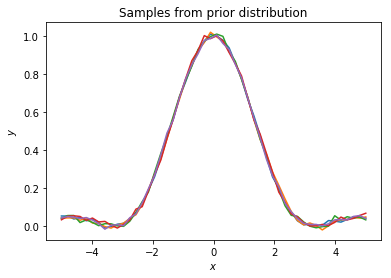

In [26]:
x = np.array([ Decimal(i) for i in x])
y = np.array( [Fraunhofe(x, [d_b, d_lambda, d_D]) for i in range(5)] )
plt.plot(x, y.T)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Samples from prior distribution');

In [27]:
def Pred_GP(CovFunc, CovPar, xobs, yobs, eobs, xtest):
    # evaluate the covariance matrix for pairs of observed inputs
    K = CovFunc(CovPar, xobs, xobs) 
    # add white noise
    K += np.identity(xobs.shape[0]) * eobs**2
    # evaluate the covariance matrix for pairs of test inputs
    Kss = CovFunc(CovPar, xtest, xtest)
    # evaluate the cross-term
    Ks = CovFunc(CovPar, xtest, xobs)
    # invert K
    Ki = inv(K)
    # evaluate the predictive mean
    m = np.dot(Ks, np.dot(Ki, yobs))
    # evaluate the covariance
    cov = Kss - np.dot(Ks, np.dot(Ki, Ks.T))
    return m, cov

In [42]:
xobs = np.array([ Decimal(np.random.uniform(-4,4)) for i in range(10)])
yobs = Fraunhofe(xobs, [d_b, d_lambda, d_D])

/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  


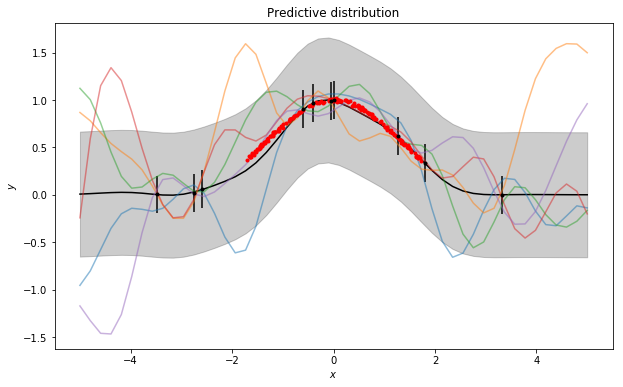

In [43]:
eobs = 0.1
xobs = xobs.astype(float)
yobs = yobs.astype(float)

plt.figure(figsize=(10,6))
m,C= Pred_GP(SEKernel,[1.0,1.0],xobs,yobs,eobs,x)
sig = np.std(np.diag(C))
samples = multivariate_normal(m,C,5)
plt.errorbar(xobs,yobs,yerr=2*eobs,capsize=0,fmt='k.')
plt.plot(x,m,'k-')
x = x.astype(float)
plt.fill_between(x,m+2*sig,m-2*sig,color='k',alpha=0.2)
plt.plot(x,samples.T,alpha=0.5)

d_I = Fraunhofe(d_x, [d_b, d_lambda, d_D])
plt.plot(d_x, d_I,'r.')

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Predictive distribution');

/Users/domi/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  


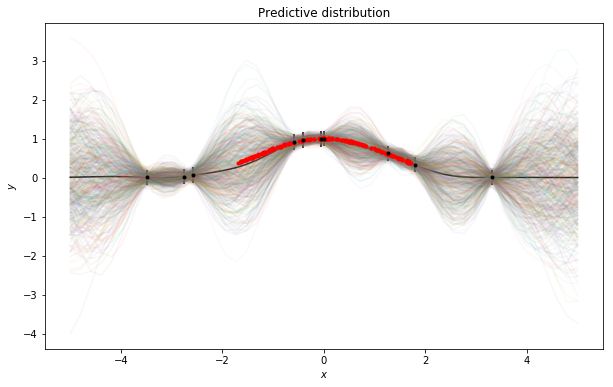

In [45]:
eobs = 0.1
xobs = xobs.astype(float)
yobs = yobs.astype(float)

plt.figure(figsize=(10,6))
m,C= Pred_GP(SEKernel,[1.0,1.0],xobs,yobs,eobs,x)
sig = np.std(np.diag(C))
samples = multivariate_normal(m,C,500)
plt.errorbar(xobs,yobs,yerr=2*eobs,capsize=0,fmt='k.')
plt.plot(x,m,'k-')
x = x.astype(float)
# plt.fill_between(x,m+2*sig,m-2*sig,color='k',alpha=0.01)
plt.plot(x,samples.T,alpha=0.05)

d_I = Fraunhofe(d_x, [d_b, d_lambda, d_D])
plt.plot(d_x, d_I,'r.')

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Predictive distribution');

## Interpretion

* There is room for alternative form of diffraction equation, but sampling is very biased and uneven
* Flat prior, is too big.
* Gaussian process regression can incooperate with biased sampling, which is more realistic
* I am not good at TensorFlow